# Topic Modelling for Urdu News and Poetry Text Using LDA, HDP and LSI 

### I'll show you two different implementation but first quickly skim through what is Topic Modelling and it's approaches

<ol>Topic modelling refers to the task of identifying topics that best describes a set of documents.</ol>
<ol> These topics will only emerge during the topic modelling process (therefore called latent)</ol>


<h3>Each document can be described by a distribution of topics and each topic can be described by a distribution of words


<img src = 'https://cdn-images-1.medium.com/max/800/1*2uj6t3gNv76SpHrWf5-z-A.jpeg'>

# Latent Semantic Analysis (LSA) or Latent Semantic Indexing (LSI)
<ol>

It is a technique in the area of NLP. The main goal of LSA  is to create vector based representation for texts to make semantic content. By vector representation LSA computes the similarity between texts to pick the similar words. Previously LSA was termed as Latent Semantic Indexing (LSI). LSA uses Singular Value Decomposition (SVD) to reorder the data.
</ol>

# SVD


<img src = "https://blogs.sas.com/content/iml/files/2017/08/svd1.png">

# LDA Latent Dirichlet Allocation
<ol>LDA is a Bayesian version of pLSA. In particular, it uses dirichlet priors for the document-topic and word-topic distributions, lending itself to better generalization.</ol>
<ol>LDA imagines a fixed set of topics. Each topic represents a set of words.</ol>
<ol>And the goal of LDA is to map all the documents to the topics in a way, such that the words in each document are mostly captured by those imaginary topics.</ol>

# HDP Hierarchical Dirichlet Process
<ol>
In statistics and machine learning, the hierarchical Dirichlet process (HDP) is a nonparametric Bayesian approach to clustering grouped data.
</ol>

# Coherence Model
<ol>
Typically, CoherenceModel used for evaluation of topic models.
</ol>

# Reading xml files from folder and dump it into a list

In [ ]:
import xml.etree.ElementTree as ET
import os
path = 'Urdu-corpus'
test = []
for filename in os.listdir(path):
    if not filename.endswith('.xml'): 
        continue
    fullname = os.path.join(path, filename)
    tree = ET.parse(fullname)
    root = tree.getroot()
    root.tag
    ET.tostring(root, encoding='utf8').decode('utf8')
    for body in root.iter('body'):
        test.append(body.text)

## Make a csv file for news corpus

In [ ]:
import csv
with open('news.csv', 'a', encoding = 'utf-8') as csvfile:
    wr = csv.writer(csvfile, delimiter='\n')
    wr.writerow(test)
    print('CSV Write Done!')

In [1]:
import os
import operator
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Preprocessing

In [2]:
import spacy
from spacy.lang.ur import Urdu
parser = Urdu()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [3]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [4]:
import nltk
stopwords = set(nltk.corpus.stopwords.words('urdu'))

In [5]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [6]:
import random
text_data = []
with open('news.csv', encoding = 'utf-8') as f:
    for line in f:
        tokens = prepare_text_for_lda(line)
        if random.random() > .99:
            print(tokens)
            text_data.append(tokens)

['سپورٹس', 'جرمنی', 'گراؤنڈ', 'تعمیر', 'افغانستان', 'معانت', 'گا۔افغانستان', 'مشرقی', 'اسٹیڈیم', 'تعمیرکے', 'جرمنی', 'تعاون', 'گا،افغانستان', 'دییجانے', 'موجود', 'تنظیم', 'معاہدے', 'کاحصہ', 'ہے۔خوست', 'افغانستان', 'اولمپک', 'کمیٹی', 'معاونت', 'کھیلوں', 'میدان', 'تعمیر', 'اسٹیدیم', 'تعمیر', 'کھیلوں', 'اضافہ', 'ٹوئنٹی', 'انغانستان', 'شمالیت', 'مقبول', 'ابھرا', '۔پاکستان', 'ملحقہ', 'تماشائیوں', 'گنجائش', 'گراؤنڈ', 'تعمیر']
['اسلام', 'اکتوبر', 'پاکستان', 'اہتمام', 'ڈومیسٹک', 'ٹورنامنٹ', 'ٹرافی', 'اتوار', 'مختلف', 'شہروں', 'دسمبر', 'ایونٹ', 'ریجنز', 'ڈیپارٹمنٹس', 'ٹیمیں', 'ٹائٹل', 'ایکشن', 'دکھائی', 'کیٹگری', 'ایونٹ', 'اسلام', 'لیپرڈز', 'کراچی', 'ڈولفنز', 'اتھارٹی', 'لاہور', 'لائنز', 'واپڈا', 'ملتان', 'ٹائیگرز', 'پشاور', 'پینتھرز', 'راولپنڈی', 'کیٹگری', 'ایونٹ', 'کراچی', 'زیبراز', 'لاہور', 'ایگلز', 'بہاولپور', 'سٹیگز', 'وولوز', 'سیالکوٹ', 'سٹالینز', 'ٹورنامنٹ', 'ابتدائی', 'کیٹگریز', 'کھیلے', 'جائیں', 'کیٹگری', 'کھیلے', 'میچوں', 'اسلام', 'لیپرڈز', 'مقابلہ', 'کراچی', 'ڈولفنز', 'مقابلہ', 'اتھا

In [7]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)

In [8]:
corpus = [dictionary.doc2bow(text) for text in text_data]

In [9]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [10]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  '0.496*"افغانستان" + 0.313*"انہوں" + 0.233*"استحکام" + 0.211*"رپورٹ" + 0.204*"پاکستان" + 0.181*"عمران" + 0.173*"افغان" + 0.131*"انسٹیٹیوٹ" + 0.131*"چائنہ" + 0.131*"سرتاج"'),
 (1,
  '0.424*"رپورٹ" + 0.359*"عمران" + -0.230*"کھلاڑی" + 0.228*"میڈیا" + 0.196*"ٹربیونل" + 0.186*"ملاقات" + -0.182*"سیریز" + -0.179*"انڈیز" + -0.179*"ہوئے۔" + 0.163*"نادرا"'),
 (2,
  '0.306*"کھلاڑی" + 0.283*"رپورٹ" + 0.241*"سیریز" + 0.240*"عمران" + 0.238*"انڈیز" + 0.238*"ہوئے۔" + -0.210*"افغانستان" + 0.204*"کیویز" + 0.170*"ساؤتھی" + 0.170*"ولیمسن"'),
 (3,
  '0.531*"مقابلہ" + 0.354*"کیٹگری" + 0.236*"کراچی" + 0.236*"لاہور" + 0.182*"اسلام" + 0.177*"دسمبر" + 0.177*"ایونٹ" + 0.119*"ٹورنامنٹ" + 0.119*"کھیلے" + 0.118*"لائنز"'),
 (4,
  '0.348*"امریکی" + 0.348*"فورسز" + -0.205*"سیلاب" + -0.203*"وزیراعظم" + 0.199*"امریکا" + -0.160*"استحکام" + 0.149*"ڈنفورڈ" + 0.149*"تعداد" + 0.149*"انخلاء" + 0.149*"القاعدہ"')]

## LSI MODEL

In [11]:
lsitopics = lsimodel.show_topics(formatted=False)

## HDP MODEL

In [12]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [13]:
hdpmodel.show_topics()

[(0,
  '0.017*افغانستان + 0.012*تعلقات + 0.011*انہوں + 0.011*استحکام + 0.010*آٹھویں + 0.009*ڈولفنز + 0.008*اظہار + 0.008*پرامن + 0.008*رکھتا + 0.007*ذریعے + 0.007*کوششوں + 0.007*عالمی + 0.007*سرتاج + 0.007*تماشائیوں + 0.007*ہوگا۔ + 0.007*افغان + 0.006*۔انہوں + 0.006*دوررس + 0.006*پاکستان + 0.006*مشترکہ'),
 (1,
  '0.024*رپورٹ + 0.016*عمران + 0.014*میڈیا + 0.010*چوہدری + 0.009*ٹربیونل + 0.009*ملاقات + 0.008*ابلاغ + 0.008*چیئرمین + 0.008*گئی،رپورٹ + 0.008*اختتامی + 0.008*کاریوں + 0.008*نادرا + 0.007*ایڈور + 0.007*سربمہر + 0.007*کلیدی + 0.007*گی۔عثمان + 0.006*جوہانسبرگ + 0.006*معلوم + 0.006*تعلقات + 0.006*ڈاکٹر'),
 (2,
  '0.014*انڈیز + 0.014*کھلاڑی + 0.013*سیریز + 0.011*ہوئے۔ + 0.010*ساؤتھی + 0.010*کیویز + 0.009*انتخابی + 0.008*ہاتھوں + 0.008*ٹرینٹ + 0.008*ڈاکٹر + 0.008*ولیمسن + 0.008*میدان + 0.008*سٹیڈیم + 0.007*کرلی۔ + 0.007*میزبان + 0.007*کی12سال + 0.007*ہولڈر + 0.007*پریتی + 0.007*موجود + 0.006*بہترین'),
 (3,
  '0.012*سیلاب + 0.009*استحکام + 0.009*وزیراعظم + 0.009*آفات + 0.009*ذریعے +

In [14]:
hdptopics = hdpmodel.show_topics(formatted=False)

## LDA MODEL

In [17]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary, passes= 15)

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

In [18]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

## LDA Visualization

In [19]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.175627  0.122872       1        1  27.434053
9      0.009515 -0.230262       2        1  24.103455
3      0.003528 -0.004825       3        1  16.334436
7     -0.241641  0.093224       4        1  13.822243
1      0.067761  0.040784       5        1  11.044620
0      0.006911  0.014632       6        1   3.823828
2     -0.012799 -0.018533       7        1   3.083607
6     -0.002889 -0.006224       8        1   0.117920
5     -0.002512 -0.005676       9        1   0.117920
4     -0.003501 -0.005992      10        1   0.117920, topic_info=     Category       Freq       Term      Total  loglift  logprob
term                                                            
4     Default  16.000000  افغانستان  16.000000  30.0000  30.0000
489   Default  11.000000      رپورٹ  11.000000  29.0000  29.0000
196   Default   7.000000     کھلاڑی   7.000000  28.0000  28.0000
262   Default   5.000000      فورسز   5.000000  27.0000  27.0000
230   Default   5.000000     امریکی   5.000000  26.0000  26.0000
62    Default   7.000000     مقابلہ   7.000000  25.0000  25.0000
470   Default  10.000000      عمران  10.000000  24.0000  24.0000
149   Default   5.000000      انڈیز   5.000000  23.0000  23.0000
206   Default   5.000000      ہوئے۔   5.000000  22.0000  22.0000
168   Default   7.000000      سیریز   7.000000  21.0000  21.0000
536   Default   5.000000      سیلاب   5.000000  20.0000  20.0000
91    Default   2.000000     خواتین   2.000000  19.0000  19.0000
133   Default   6.000000     جولائی   6.000000  18.0000  18.0000
203   Default   4.000000      کیویز   4.000000  17.0000  17.0000
442   Default   6.000000     ملاقات   6.000000  16.0000  16.0000
497   Default   6.000000      میڈیا   6.000000  15.0000  15.0000
104   Default   3.000000     ۔انہوں   3.000000  14.0000  14.0000
8     Default   3.000000      تعمیر   3.000000  13.0000  13.0000
81    Default   5.000000     کیٹگری   5.000000  12.0000  12.0000
166   Default   4.000000     ساؤتھی   4.000000  11.0000  11.0000
187   Default   4.000000     ولیمسن   4.000000  10.0000  10.0000
205   Default   4.000000     ہاتھوں   4.000000   9.0000   9.0000
449   Default   6.000000   وزیراعظم   6.000000   8.0000   8.0000
501   Default   5.000000    ٹربیونل   5.000000   7.0000   7.0000
378   Default   7.000000    استحکام   7.000000   6.0000   6.0000
226   Default   5.000000      افغان   5.000000   5.0000   5.0000
498   Default   4.000000      نادرا   4.000000   4.0000   4.0000
229   Default   3.000000     امریکا   3.000000   3.0000   3.0000
193   Default   5.000000    کامیابی   5.000000   2.0000   2.0000
189   Default   3.000000      ٹرینٹ   3.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
206   Topic10   0.002327      ہوئے۔   5.557898  -1.0356  -6.3051
203   Topic10   0.002319      کیویز   4.830754  -0.8989  -6.3086
193   Topic10   0.002321    کامیابی   5.871617  -1.0931  -6.3077
149   Topic10   0.002317      انڈیز   5.558163  -1.0399  -6.3093
449   Topic10   0.002320   وزیراعظم   6.734556  -1.2305  -6.3080
46    Topic10   0.002300      دسمبر   2.921921  -0.4043  -6.3167
43    Topic10   0.002292   بہاولپور   2.103805  -0.0792  -6.3202
37    Topic10   0.002315      اسلام   6.100410  -1.1337  -6.3101
66    Topic10   0.002290      وولوز   2.103885  -0.0800  -6.3209
65    Topic10   0.002290      واپڈا   2.103907  -0.0801  -6.3211
73    Topic10   0.002290      پشاور   2.103928  -0.0801  -6.3211
64    Topic10   0.002295      میچوں   2.740229  -0.3421  -6.3188
187   Topic10   0.002304     ولیمسن   4.103820  -0.7422  -6.3150
36    Topic10   0.002288    اتھارٹی   2.103912  -0.0808  -6.3217
166   Topic10   0.002304     ساؤتھی   4.103776  -0.7423  -6.3151
56    Topic10   0.002287      فائنل   2.103981  -0.0812  -6.3221
194   Topic10   0.002292      کرلی۔   2.649322  -0.3095  -6.3199
189   Topic10   0.002297      ٹرینٹ   3.376562  -0.5499  -6

In [23]:
def evaluate_graph(dictionary, corpus, texts, limit):
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=corpus, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
    return lm_list, c_v

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

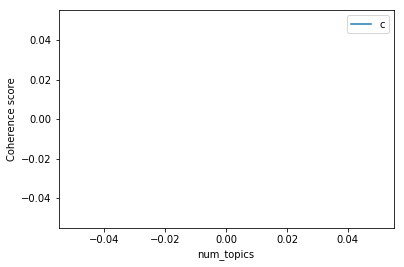

Wall time: 50.4 s


In [24]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=corpus, limit=10)

## LSI Visualization

In [56]:
pyLDAvis.gensim.prepare(lmlist[8], corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.108675 -0.034212       1        1  37.784069
5     -0.129167 -0.066722       2        1  21.437738
6     -0.013531 -0.039469       3        1  11.057720
0      0.013726 -0.079161       4        1  10.351324
8      0.072953  0.052635       5        1  10.131870
4     -0.131766  0.078952       6        1   5.138278
1      0.030723  0.028930       7        1   3.836929
2      0.054129  0.027823       8        1   0.131034
3     -0.005743  0.031223       9        1   0.131034, topic_info=     Category       Freq       Term      Total  loglift  logprob
term                                                            
4     Default  16.000000  افغانستان  16.000000  30.0000  30.0000
234   Default  14.000000      انہوں  14.000000  29.0000  29.0000
378   Default   6.000000    استحکام   6.000000  28.0000  28.0000
449   Default   5.000000   وزیراعظم   5.000000  27.0000  27.0000
72    Default  12.000000    پاکستان  12.000000  26.0000  26.0000
536   Default   3.000000      سیلاب   3.000000  25.0000  25.0000
419   Default   4.000000      سرتاج   4.000000  24.0000  24.0000
226   Default   5.000000      افغان   5.000000  23.0000  23.0000
62    Default   5.000000     مقابلہ   5.000000  22.0000  22.0000
455   Default   3.000000      چائنہ   3.000000  21.0000  21.0000
390   Default   4.000000  انسٹیٹیوٹ   4.000000  20.0000  20.0000
8     Default   2.000000      تعمیر   2.000000  19.0000  19.0000
196   Default   6.000000     کھلاڑی   6.000000  18.0000  18.0000
168   Default   6.000000      سیریز   6.000000  17.0000  17.0000
108   Default   6.000000      انہیں   6.000000  16.0000  16.0000
133   Default   5.000000     جولائی   5.000000  15.0000  15.0000
81    Default   3.000000     کیٹگری   3.000000  14.0000  14.0000
457   Default   2.000000    ڈائیلاگ   2.000000  13.0000  13.0000
307   Default   3.000000      تعریف   3.000000  12.0000  12.0000
262   Default   5.000000      فورسز   5.000000  11.0000  11.0000
230   Default   4.000000     امریکی   4.000000  10.0000  10.0000
206   Default   5.000000      ہوئے۔   5.000000   9.0000   9.0000
149   Default   5.000000      انڈیز   5.000000   8.0000   8.0000
557   Default   2.000000      کشمیر   2.000000   7.0000   7.0000
518   Default   2.000000     بارشوں   2.000000   6.0000   6.0000
37    Default   5.000000      اسلام   5.000000   5.0000   5.0000
193   Default   6.000000    کامیابی   6.000000   4.0000   4.0000
382   Default   3.000000      اظہار   3.000000   3.0000   3.0000
358   Default   3.000000      پرامن   3.000000   2.0000   2.0000
291   Default   4.000000     آپریشن   4.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
2      Topic9   0.005568    اسٹیڈیم   0.771138   1.7067  -5.5379
17     Topic9   0.005536      معانت   0.772105   1.6997  -5.5437
16     Topic9   0.005448      مشرقی   0.774785   1.6801  -5.5598
20     Topic9   0.005406      مقبول   0.776044   1.6707  -5.5675
11     Topic9   0.005404      تنظیم   0.776094   1.6704  -5.5678
32     Topic9   0.005297    ہے۔خوست   0.779324   1.6463  -5.5878
14     Topic9   0.005235     سپورٹس   0.781220   1.6319  -5.5997
10     Topic9   0.005230  تماشائیوں   0.781362   1.6308  -5.6006
21     Topic9   0.005009      ملحقہ   0.788045   1.5791  -5.6438
1      Topic9   0.004742    اسٹیدیم   0.796120   1.5141  -5.6986
33     Topic9   0.004724   ۔پاکستان   0.796663   1.5096  -5.7024
25     Topic9   0.006617      کاحصہ   1.232575   1.4103  -5.3653
22     Topic9   0.006577      موجود   1.400774   1.2763  -5.3714
7      Topic9   0.008357      تعاون   1.786986   1.2723  -5.1319
536    Topic9   0.015034      سیلاب   3.539151   1.1762  -4.5447
557    Topic9   0.009637      کشمیر   2.231697   1.1926  -4.9894
449    Topic9   0.015659   وزیراعظم   5.318307   0.8096  -4.5039
81     Topic9   0.010402     کیٹگری   3.429373   0.8394  -4.9130
4      Topic9   0.020742  افغانستان  16.438229  

In [26]:
lmtopics = lmlist[5].show_topics(formatted=False)

In [27]:
def ret_top_model():
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = LdaModel(corpus=corpus, id2word=dictionary)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=corpus, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [28]:
lm, top_topics = ret_top_model()

C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Pcw\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

In [30]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[('ادارہ', 0.0017793593),
  ('اسٹیشنوں', 0.0017793593),
  ('۔انہیں', 0.0017793593),
  ('۔علاقے', 0.0017793593),
  ('اتحاد', 0.0017793593),
  ('اتفاق', 0.0017793593),
  ('اختتامی', 0.0017793593),
  ('ہمراہ', 0.0017793593),
  ('استحکام', 0.0017793593),
  ('اظہار', 0.0017793593)],
 [('ادارہ', 0.0017793593),
  ('اسٹیشنوں', 0.0017793593),
  ('۔انہیں', 0.0017793593),
  ('۔علاقے', 0.0017793593),
  ('اتحاد', 0.0017793593),
  ('اتفاق', 0.0017793593),
  ('اختتامی', 0.0017793593),
  ('ہمراہ', 0.0017793593),
  ('استحکام', 0.0017793593),
  ('اظہار', 0.0017793593)],
 [('افغانستان', 0.036709707),
  ('استحکام', 0.02988504),
  ('انہوں', 0.023134502),
  ('پاکستان', 0.01852407),
  ('سرتاج', 0.017879),
  ('انسٹیٹیوٹ', 0.015446962),
  ('چائنہ', 0.015229434),
  ('ڈائیلاگ', 0.014065677),
  ('پالیسی', 0.01058333),
  ('افغان', 0.010303989)],
 [('ادارہ', 0.0017793593),
  ('اسٹیشنوں', 0.0017793593),
  ('۔انہیں', 0.0017793593),
  ('۔علاقے', 0.0017793593),
  ('اتحاد', 0.0017793593),
  ('اتفاق', 0.0017793593),
  (

In [59]:
def ret_top_model():
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = LsiModel(corpus=corpus, id2word=dictionary)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=corpus, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [60]:
lm, top_topics = ret_top_model()

In [61]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[('افغانستان', 0.4956885071958875),
  ('انہوں', 0.312813739800549),
  ('استحکام', 0.23266194921806732),
  ('رپورٹ', 0.21113587598276828),
  ('پاکستان', 0.20353724178511634),
  ('عمران', 0.18120868925089842),
  ('افغان', 0.17315458112465942),
  ('انسٹیٹیوٹ', 0.13066822761122773),
  ('سرتاج', 0.13066822761122773),
  ('چائنہ', 0.13066822761122773)],
 [('رپورٹ', 0.4236624929295226),
  ('عمران', 0.35904723181001175),
  ('کھلاڑی', -0.22993388818640495),
  ('میڈیا', 0.22812595773128125),
  ('ٹربیونل', 0.19553653519824085),
  ('ملاقات', 0.18611624827986986),
  ('سیریز', -0.18158059611131144),
  ('ہوئے۔', -0.17883746858942617),
  ('انڈیز', -0.17883746858942612),
  ('نادرا', 0.16294711266520098)],
 [('کھلاڑی', 0.3058462421451551),
  ('رپورٹ', 0.2832001484491204),
  ('سیریز', 0.2409477446414988),
  ('عمران', 0.23953481048700523),
  ('ہوئے۔', 0.23788041055734252),
  ('انڈیز', 0.2378804105573424),
  ('افغانستان', -0.20962946768212565),
  ('کیویز', 0.20389749476343652),
  ('ہاتھوں', 0.1699145789695

In [62]:
def ret_top_model():
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = HdpModel(corpus=corpus, id2word=dictionary)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=corpus, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [63]:
lm, top_topics = ret_top_model()

In [ ]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])